In [1]:
import sys, os
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.nn import *

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='../../data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='../../data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [3]:
print(train_dataset.data.max())
print(train_dataset.data.shape)
print(train_dataset.targets)

tensor(255, dtype=torch.uint8)
torch.Size([60000, 28, 28])
tensor([9, 0, 0,  ..., 3, 0, 5])


In [4]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [5]:
class CNN(nn.Module):
    def __init__(self, K: int):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1,  out_channels=32,  kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64,  kernel_size=3, stride=2), nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2), nn.ReLU(),
        )

        # http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        # No zero padding, mom-unit stridea
        # https://pytorch.org/docs/stable/nn.html
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128 * 2 * 2, 512), 
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, K)
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        
        return out

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CNN(K)
model.to(device)

print(device)

cuda:0


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [9]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, 15, device
)

Epoch 1/15, Train Loss: 0.6780, Test Loss: 0.4910, Duration: 0:00:13.109048
Epoch 2/15, Train Loss: 0.4484, Test Loss: 0.4128, Duration: 0:00:11.996129
Epoch 3/15, Train Loss: 0.3888, Test Loss: 0.3657, Duration: 0:00:11.920253
Epoch 4/15, Train Loss: 0.3508, Test Loss: 0.3435, Duration: 0:00:11.997246
Epoch 5/15, Train Loss: 0.3277, Test Loss: 0.3304, Duration: 0:00:11.624746
Epoch 6/15, Train Loss: 0.3097, Test Loss: 0.3084, Duration: 0:00:11.795607
Epoch 7/15, Train Loss: 0.2901, Test Loss: 0.3131, Duration: 0:00:11.874932
Epoch 8/15, Train Loss: 0.2753, Test Loss: 0.2993, Duration: 0:00:11.586222
Epoch 9/15, Train Loss: 0.2612, Test Loss: 0.3034, Duration: 0:00:11.405136
Epoch 10/15, Train Loss: 0.2498, Test Loss: 0.2876, Duration: 0:00:11.762409
Epoch 11/15, Train Loss: 0.2357, Test Loss: 0.2979, Duration: 0:00:11.487481
Epoch 12/15, Train Loss: 0.2282, Test Loss: 0.2823, Duration: 0:00:11.678641
Epoch 13/15, Train Loss: 0.2161, Test Loss: 0.2819, Duration: 0:00:11.358384
Epoch 14

Train accuracy: tensor(0.9439, device='cuda:0')
Test accuracy: tensor(0.8994, device='cuda:0')


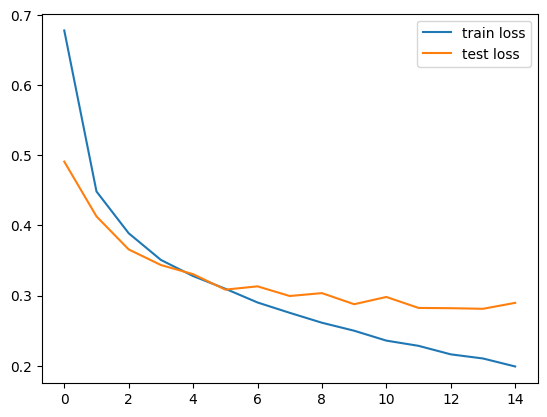

In [10]:
print("Train accuracy:", compute_accuracy(model, train_loader, device))
print("Test accuracy:", compute_accuracy(model, test_loader, device))

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

[[842   1  31  21   2   1  98   0   4   0]
 [  2 980   0  13   1   0   3   0   1   0]
 [ 13   0 845   7  65   0  70   0   0   0]
 [ 25   7  21 895  30   1  20   0   1   0]
 [  0   1  60  28 832   0  78   0   1   0]
 [  1   0   1   0   1 963   0  21   2  11]
 [130   2  78  35 102   0 646   0   7   0]
 [  0   0   0   0   0  12   0 938   1  49]
 [  4   1  16   3   3   1   5   3 964   0]
 [  1   0   0   0   0   8   0  23   0 968]]
Confusion matrix, without normalization


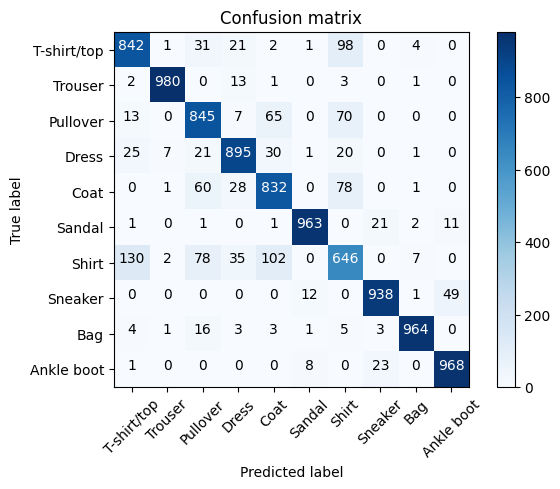

In [13]:
# get all predictions in an array and plot confusion matrix
confusion_matrix = get_confusion_matrix(test_loader, model, device)
print(confusion_matrix)

plot_confusion_matrix(confusion_matrix, [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
])